# Regression and geography

When trying to determine the effect of some (independent) variables on
the outcome of phenomena (dependent variable), you often use regression
to model such an outcome and understand the influence each of the
variables has in the model. With spatial regression, it is the same. You
just need to use the spatial dimension in a mindful way.

This session provides an introduction to ways of incorporating space
into regression models, from spatial variables in standard linear
regression to geographically weighted regression.

In [1]:
import esda
import geopandas as gpd
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from libpysal import graph
from splot.esda import lisa_cluster

## Data

You will work with the same data you already used in the session on
[spatial autocorrelation](../autocorrelation/hands_on.qmd) - the results
of the second round of the presidential elections in Czechia in 2023,
between Petr Pavel and Andrej Babiš, on a level of municipalities. You
can read the election data directly from the original location.

In [2]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
elections.head()

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> elections = gpd.read_file(
>     "cz_elections_2023.gpkg",
> )
> ```

The election results give you the dependent variable - you will look at
the percentage of votes Petr Pavel, the winner, received. From the [map
of the results](../autocorrelation/hands_on.qmd#code-cell-2) and the
analysis you did when exploring spatial autocorrelation you already know
that there are some significant spatial patterns. Let’s look whether
these patterns correspond to the composition of education levels within
each municipality.

You can use the data from the [Czech Statistical
Office](https://www.czso.cz/csu/czso/vysledky-scitani-2021-otevrena-data)
reflecting the situation during the Census 2021. The original table has
been [preprocessed](../data/cz_education_2021/preprocessing.ipynb) and
is available as a CSV.

In [3]:
education = pd.read_csv(
    "https://martinfleischmann.net/sds/regression/data/education.csv"
)
education.head()

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](%22https://martinfleischmann.net/sds/regression/data/education.csv%22)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> education = pd.read_csv(
>     "education.csv",
> )
> ```

The first thing you need to do is to merge the two tables, to have both
dependent and independent variables together. The municipality code in
the `elections` table is in the `"nationalCode"` column, while in the
education table in the `"uzemi_kod"` column.

In [4]:
elections_data = elections.merge(education, left_on="nationalCode", right_on="uzemi_kod")
elections_data.head()

5 rows × 21 columns

That is all sorted and ready to be used in a regression.

## Non-spatial linear regression

Before jumping into spatial regression, let’s start with the standard
linear regression. A useful start is to explore the data using an
ordinary least squares (OLS) linear regression model.

### OLS model

While this course is not formula-heavy, in this case, it is useful to
use the formula to explain the logic of the algorithm. The OLS tries to
model the dependent variable $y$ as the linear combination of
independent variables $x_1, x_2, ... x_n$:

$$y_{i}=\alpha+\beta _{1}\ x_{i1}+\beta _{2}\ x_{i2}+\cdots +\beta _{p}\ x_{ip}+\varepsilon _{i}$$

where $\epsilon_{i}$ represents unobserved random variables and $\alpha$
represents an intercept - a constant. You know the $y_i$, all of the
$x_i$ and try to estimate the coefficients. In Python, you can run
linear regression using implementations from more than one package
(e.g., `statsmodels`, `scikit-learn`, `spreg`). This course covers
`statsmodels` approach as it has a nice API to work with.

First, you need a list of names of independent variables. That is equal
to column names without a few of the columns that represent other data.

In [5]:
independent_names = education.columns.drop(["uzemi_kod", "okres"])
independent_names

Index(['without_education', 'undetermined', 'incomplete_primary_education',
       'lower_secondary_and_secondary_education', 'further_education',
       'post_maturita_studies', 'bachelors_degree', 'doctoral_degree',
       'masters_degree', 'higher_vocational_education',
       'higher_vocational_education_in_a_conservatory', 'primary_education',
       'complete_secondary_vocational_education',
       'complete_secondary_general_education'],
      dtype='object')

`statsmodels` (above imported as `sm`) offers an intuitive formula API
to define the linear regression.

In [6]:
formula = f"PetrPavel ~ {' + '.join(independent_names)}"
formula

'PetrPavel ~ without_education + undetermined + incomplete_primary_education + lower_secondary_and_secondary_education + further_education + post_maturita_studies + bachelors_degree + doctoral_degree + masters_degree + higher_vocational_education + higher_vocational_education_in_a_conservatory + primary_education + complete_secondary_vocational_education + complete_secondary_general_education'

With the formula ready, you can fit the model and estimate all betas and
$\varepsilon$.

In [7]:
ols = sm.ols(formula, data=elections_data).fit()

The `ols` object offers a handy `summary()` function providing most of
the results from the fitting in one place.

In [8]:
ols.summary()

Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified. [2] The smallest eigenvalue is 4.03e-29. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.

It is clear that education composition has a significant effect on the
outcome of the elections but can explain only about 42% of its variance
(adjusted $R^2$ is 0.422). A higher amount of residents with only
primary education tends to lower Pavel’s gain while a higher amount of
university degrees tends to increase the number of votes he received.
That is nothing unexpected. However, let’s make use of geography and
unpack these results a bit.

### Spatial exploration of the model (hidden structures)

Start with the visualisation of the prediction the OLS model produces
using the coefficients shown above.

In [9]:
predicted = ols.predict(elections_data)
predicted.head()

0    41.731952
1    58.447707
2    73.554706
3    53.281638
4    48.993730
dtype: float64

Make a plot comparing the prediction with the actual results.

In [10]:
f, axs = plt.subplots(2, 1, figsize=(7, 8))
elections_data.plot(
    predicted, legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[0]
)
elections_data.plot(
    "PetrPavel", legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[1]
)
axs[0].set_title("OLS prediction")
axs[1].set_title("Actual results")

axs[0].set_axis_off()
axs[1].set_axis_off()

The general patterns are captured but there are some areas of the
country which seem to be quite off. The actual error between prediction
and the dependent variable is captured as *residuals*, which are
directly available in `ols` as `ols.resid` attribute. Let’s plot to get
a better comparison.

In [11]:
elections_data["residual"] = ols.resid
max_residual = ols.resid.abs().max()
ax = elections_data.plot(
    "residual", legend=True, cmap="RdBu", vmin=-max_residual, vmax=max_residual
)
ax.set_axis_off()

All of the municipalities in blue (residual above 0) have reported
higher gains for Petr Pavel than the model assumes based on education
structure, while all in red reported lower gains than what is expected.
However, as data scientists, we have better tools to analyse the spatial
structure of residuals than eyeballing it. Let’s recall the session on
spatial autocorrelation again and figure out the spatial clusters of
residuals.

First, create a contiguity graph and row-normalise it.

In [12]:
contiguity_r = graph.Graph.build_contiguity(elections_data).transform("r")

Then you can generate a Moran plot of residuals. For that, you will need
the lag of residuals.

In [13]:
elections_data["residual_lag"] = contiguity_r.lag(elections_data["residual"])

And then you can use the code from the earlier session to generate a
Moran scatterplot using `seaborn`.

In [14]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="residual",
    y="residual_lag",
    data=elections_data,
    marker=".",
    scatter_kws={"alpha": 0.2},
    line_kws=dict(color="lightcoral")
)
plt.axvline(0, c="black", alpha=0.5)
plt.axhline(0, c="black", alpha=0.5);

That looks like a pretty strong relationship. Use the local version of
Moran’s statistic to find out the clusters.

In [15]:
lisa = esda.Moran_Local(elections_data['residual'], contiguity_r.to_W())

Let’s use our handy `lisa_cluster` function from `splot` to visualise
the results.

In [16]:
_ = lisa_cluster(lisa, elections_data)

The outcome of LISA shows large clusters of both overpredicted
(high-high) and underpredicted (low-low) areas. The underpredicted are
mostly in central Bohemia around Prague and in the mountains near the
borders, where the ski resorts are. Putting aside the central areas for
a bit, the explanation of underprediction in mountains is relatively
straightforward. The education data are linked to the residents of each
municipality. The people who voted in a municipality do not necessarily
need to match with residents. It is known that more affluent population
groups, who are more likely to go to a ski resort, voted overwhelmingly
for Pavel. And since the elections were in winter, a lot of them likely
voted in ski resorts, affecting the outcome of the model.

The overpredicted areas, on the other hand, are known for higher levels
of deprivation, which may have played a role in the results. What is
clear, is that geography plays a huge role in the modelling of the
elections.

## Spatial heterogeneity

Not all areas behave equally, it seems that some systematically vote for
Pavel more than for Babiš while others vote for him less. You need to
account for this when building a regression model. One way is by
capturing *spatial heterogeneity*. It implicitly assumes that the
outcome of the model spatially varies. You can expect $\alpha$ to vary
across space, or individual values of $\beta$. Spatial fixed effects
capture the former.

### Spatial fixed effects

You need to find a way to let $\alpha$ change across space. One option
is through the proxy variable capturing higher-level geography. You have
information about *okres* (the closest translation to English would
probably be district or county) each municipality belongs to. Let’s
start by checking if that could be useful by visualising residuals
within each. While you can use the box plot directly, it may be better
to sort the values by median residuals, so let’s complicate the code a
bit.

In [17]:
medians = (
    elections_data.groupby("okres")
    .residual.median()
    .to_frame("okres_residual")
)
f, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(
    data=elections_data.merge(
        medians, how="left", left_on="okres", right_index=True
    ).sort_values("okres_residual"),
    x="okres",
    y="residual",
)
_ = plt.xticks(rotation=90)

There are clear differences among these geographies, with a gradient
between median -16.5 and 8.3. In a model that does not show spatial
heterogeneity across higher-level geographies like these, all medians
would be close to zero. This is positive information as it indicates,
that we can encode these geographies in the model as a spatial proxy.
Using `statsmodels`, you can adapt the equation and include `"okres"` as
a dummy variable.

In [18]:
formula_fe = f"PetrPavel ~ {' + '.join(independent_names)} + okres - 1"
ols_fe = sm.ols(formula_fe, data=elections_data).fit()

Since every unique value in the `"okres"` column is now treated as a
unique variable the summary is a bit longer than before.

In [19]:
ols_fe.summary()

Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified. [2] The smallest eigenvalue is 2.07e-30. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.

The coefficients for each of the values of the categorical variable
`"okres"` are considered spatial fixed effects. You can extract just
those from the model by getting the `.params` `Series` and filtering it.

In [20]:
fixed_effects = ols_fe.params.filter(like="okres")
fixed_effects.head()

okres[Benešov]        2.551453
okres[Beroun]         4.351734
okres[Blansko]       -1.023745
okres[Brno-město]    -3.681027
okres[Brno-venkov]    1.941320
dtype: float64

You can see that if you want to join this Series to the original
DataFrame, you need to extract the names of each *okres* from within the
square brackets.

In [21]:
fixed_effects.index = fixed_effects.index.str.strip(
    "okres["
).str.strip("]")
fixed_effects.head()

Benešov        2.551453
Beroun         4.351734
Blansko       -1.023745
Brno-město    -3.681027
Brno-venkov    1.941320
dtype: float64

The resulting Series can be merged with the `elections_data`, allowing
us to map the spatial fixed effects.

In [22]:
max_effect = fixed_effects.abs().max()
elections_data.merge(
    fixed_effects.to_frame("fixed_effect"),
    left_on="okres",
    right_index=True,
    how="left",
).plot(
    "fixed_effect", legend=True, vmin=-max_effect, vmax=max_effect, cmap="PRGn"
).set_axis_off()

> **Spatial regimes and spatial dependence**
>
> Where spatial fixed effects allow $\alpha$ to change geographically
> (within each *okres*), spatial regimes allow $\beta_k$ to change
> within the same regions. Spatial regimes cannot be done within
> `statsmodels` as they require more specialised treatment offered by
> the `spreg` package. Check the [Spatial
> regimes](https://geographicdata.science/book/notebooks/11_regression.html#spatial-regimes)
> sections of the[*Spatial
> Regression*](https://geographicdata.science/book/notebooks/11_regression.html)
> chapter from the Geographic Data Science with Python by
> @rey2023geographic for more details.
>
> The same chapter also covers the modelling of spatial dependence using
> `spreg`. Both are considered advanced usage within this course but
> feel free to read through the materials yourself.

With spatial fixed effects, you were able to include spatial dimension
in the model through a proxy variable, resulting in an improvement of
adjusted $R^2$ from 0.422 to 0.565 while also extracting the fixed
effect of each *okres*. However, the model is still global. We are not
able to determine how explanatory is education composition regionally.

## Geographically weighted regression

Geographically Weighted Regression (GWR) overcomes the limitation of the
OLS, which provides a single global estimate by examining how the
relationship between a dependent variable and independent variable
changes across different geographic locations. It does this by moving a
search window through the dataset, defining regions around each
regression point, and fitting a regression model to the data within each
region. This process is repeated for all the sample points in the
dataset, resulting in localized estimates. These local estimates can
then be mapped to visualize variations in variable relationships at
different locations. However, for a dataset with 6254 observations, like
the one used here, GWR will fit 6254 weighted regression models. That
can eventually pose a limitation when dealing with larger datasets, for
which fitting the GWR can take too long.

Visually, you can imagine a spatial kernel being constructed around each
location (point, specifically) where the kernel function defines its
shape and bandwidth its size, as illustrated in
<a href="#fig-kernels" class="quarto-xref">Figure 1</a>.

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div width="50.0%"
data-layout-align="left">
<figure id="fig-bandwidth">
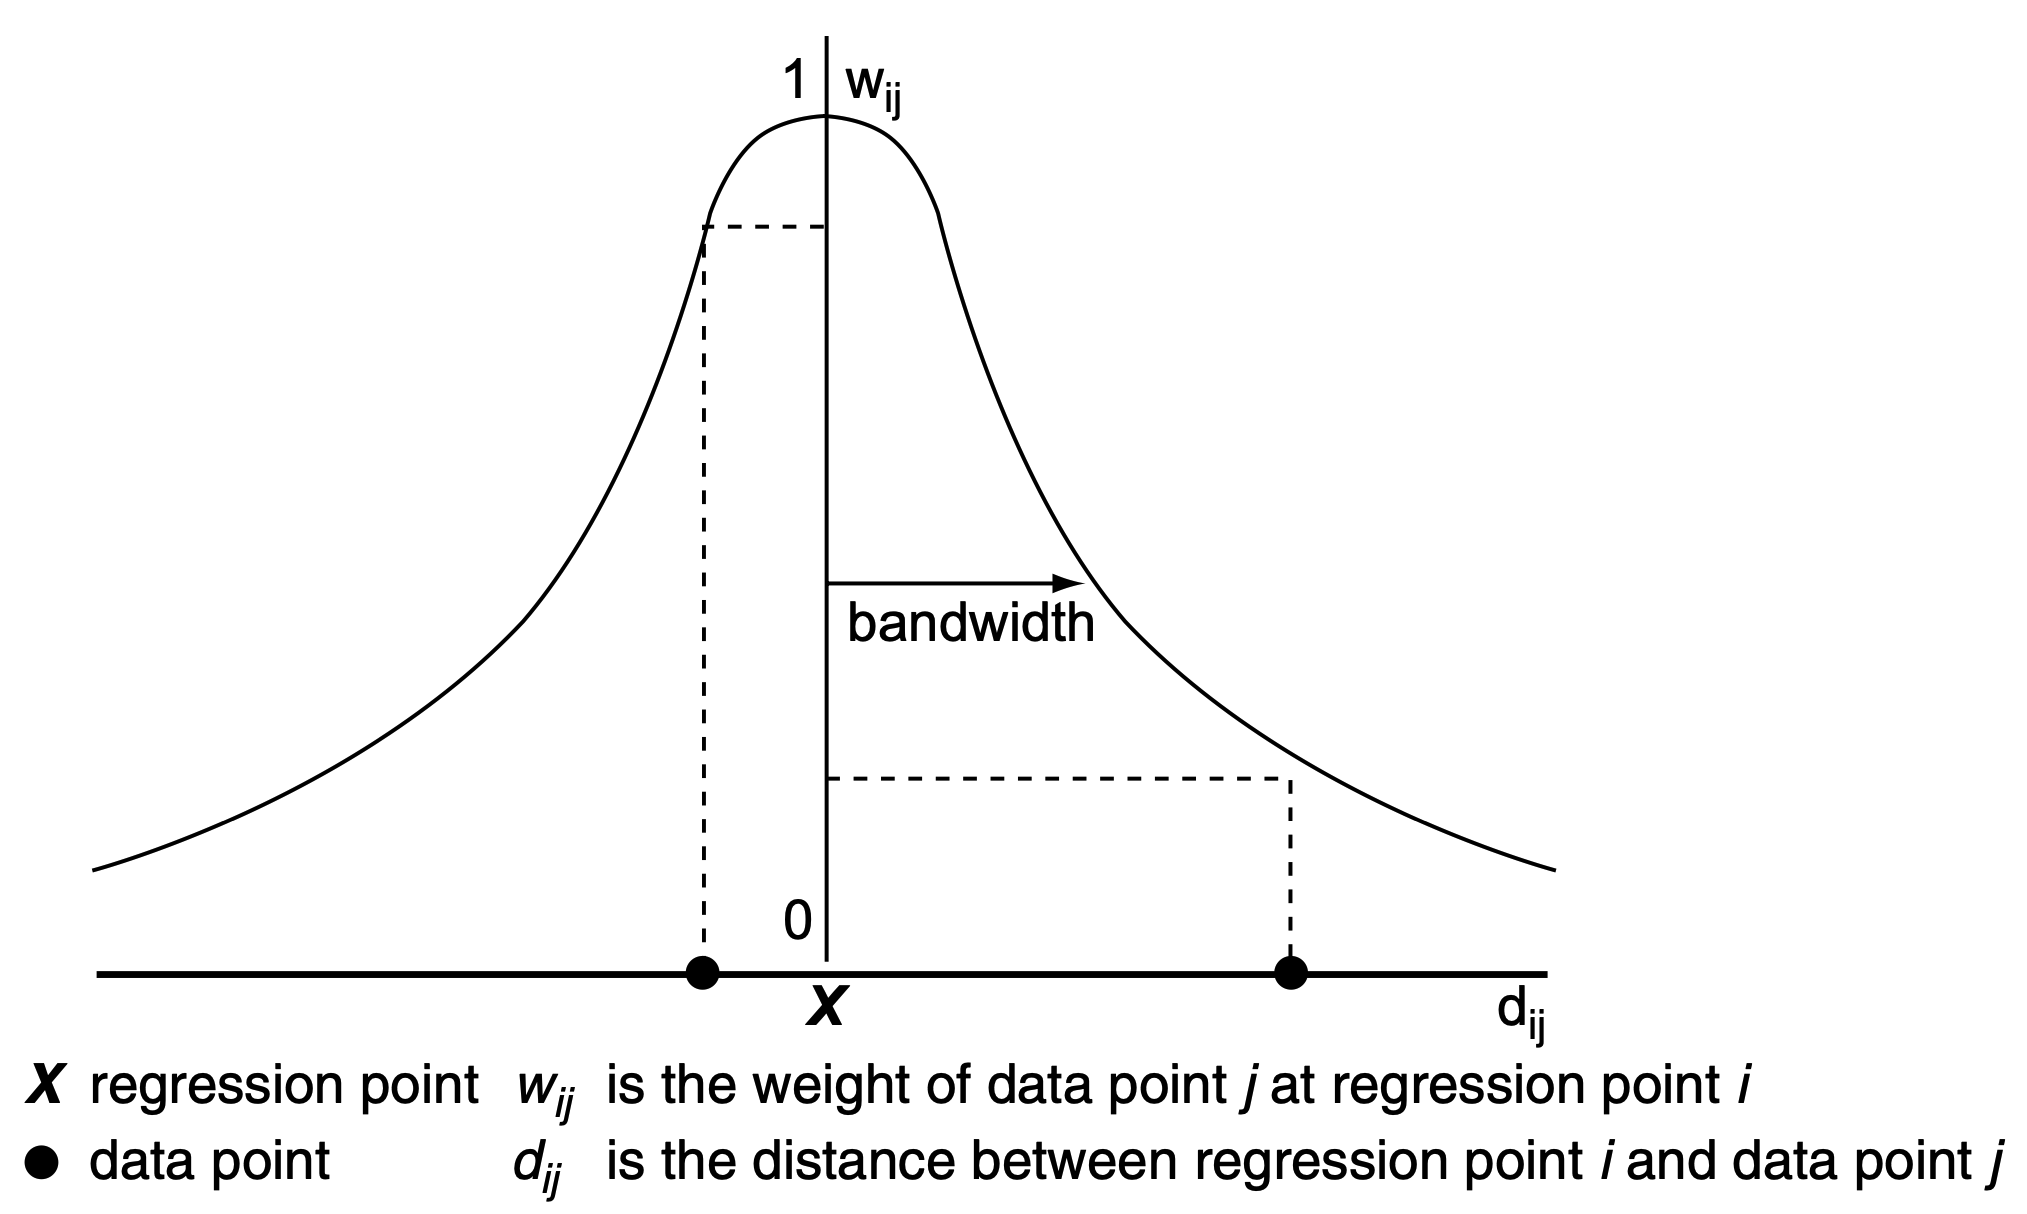
<figcaption>(a) Illustration of bandwidth and its relation to
weight.</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div width="50.0%"
data-layout-align="left">
<figure id="fig-kernel">
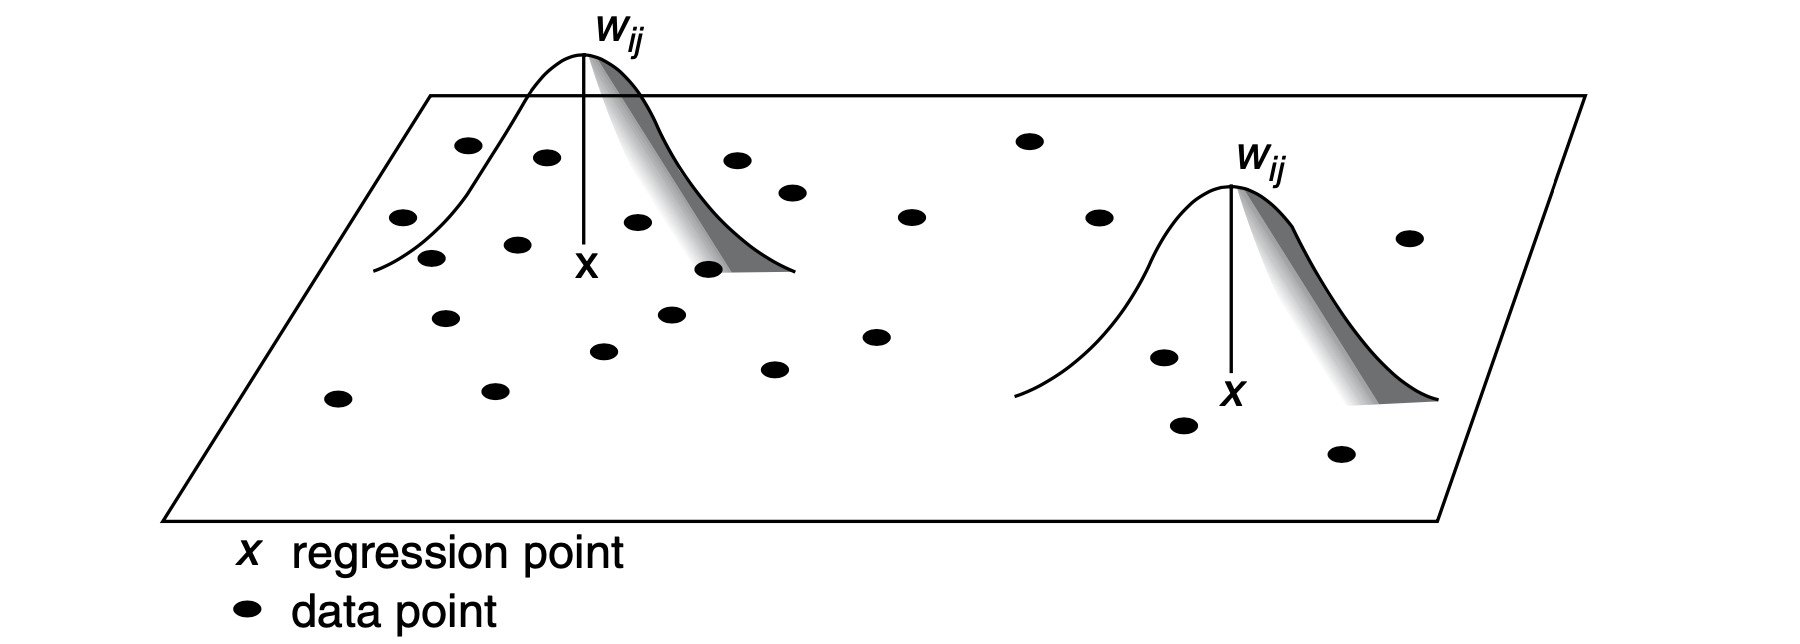
<figcaption>(b) Illustration of two spatial kernels across a point
pattern.</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 1: Illustrations of kernels. Reproduced from Fotheringham et al.
\[-@fotheringham2002geographically, pp.44-45\]

With kernels being the core of the GWR method, their specification
significantly affects the resulting model. You can specify three
parameters:

-   **Kernel shape**: The shape of the curve formed by the kernel. In
    `mgwr` package used here, `"bisquare"`, `"gaussian"`, and
    `"exponential"` kernels are supported.
-   **Kernel size**: The bandwidth distance specifying how large is the
    moving window.
-   **Bandwidth adaptivity**: Bandwidth can be either fixed, specified
    by the metric distance, where the moving window is essentially
    formed as a buffer around a point, or adaptive, specified by the
    number of nearest neighbours.

The details of the implications of the choices are beyond the scope of
this lesson but are discussed in-depth by
@fotheringham2002geographically.

### Fixed bandwidth

The method can be illustrated on a GWR using a fixed bandwidth and the
default bi-square kernel.

#### Bandwidth selection

You may have some theoretically defined bandwidth (e.g. you know that
you want to consider only locations closer than 25 km) or use
cross-validation to find the optimal bandwidth programmatically. CV can
be an expensive procedure as the selection procedure fits models based
on different bandwidths and compares residuals to choose the one where
those are minimised. `mgwr` has the `mgwr.sel_bw.Sel_BW` function that
helps you with the search. But before using it (or any other `mgwr`
function), you need to prepare the data in the correct form.

As mentioned above, the GWR assumes point locations as those are
well-defined within the distance search (unlike polygons), so you need
to extract centroids from geometries and get their coordinates.

In [23]:
coords = elections_data.centroid.get_coordinates().values
coords

array([[ -850410.51852285,  -994320.67123109],
       [ -593313.18017394, -1149911.22029507],
       [ -749835.86565295, -1163643.97264363],
       ...,
       [ -643316.42508618, -1080131.19290794],
       [ -681632.98081662, -1178150.00416665],
       [ -757365.40441225, -1083270.55289191]])

Since `mgwr` is designed to work with numpy objects rather than pandas,
extract both dependent and independent variables as arrays.

In [24]:
y = elections_data[f"PetrPavel"].values.reshape(-1, 1)
X = elections_data[independent_names[1:]].values

With the data ready, you can identify the optimal bandwidth. This step
may take some time (probably minutes).

In [25]:
sel_bw = mgwr.sel_bw.Sel_BW(coords, y, X, fixed=True)
bw = sel_bw.search()
bw

/home/runner/micromamba/envs/sds/lib/python3.11/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.94411e-21): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/runner/micromamba/envs/sds/lib/python3.11/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.33013e-22): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/runner/micromamba/envs/sds/lib/python3.11/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.5851e-21): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/runner/micromamba/envs/sds/lib/python3.11/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.12331e-20): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)

34168.16

The optimal fixed bandwidth seems to be a bit more than 34 kilometres.
You can pass it to the `GWR` function and fit the regression.

In [26]:
fixed_bandwidth = mgwr.gwr.GWR(
    coords, y, X, bw=bw, fixed=True, name_x=independent_names[1:]
)
results = fixed_bandwidth.fit()

As before, you can use a summary method.

In [27]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                6254
Number of covariates:                                                    14

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         472435.355
Log-likelihood:                                                  -22397.315
AIC:                                                              44822.630
AICc:                                                             44824.707
BIC:                                                             417891.662
R2:                                                                   0.423
Adj. R2:                                                              0.422

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The function fits GWR but also OLS for comparison and prints its results
under the Global Regression Results section. You can see that the
performance matches the first model done with `statsmodels` above. The
performance of the GWR based on the adjusted $R^2$ is 0.651, another
improvement over the fixed effects OLS model. It is probably as good as
it can be given the data on education can explain only a part of the
election behaviour.

Apart from the global $R^2$, GWR can report $R^2$ per geometry, giving
us further insights into where education is the driver of the election
result and where you need to look for other causes.

In [28]:
elections_data["local_r2"] = results.localR2
elections_data.plot("local_r2", legend=True, vmin=0, vmax=1).set_axis_off()

Higher local $R^2$ means that the model is able to use the data at each
municipality and its surrounding areas to provide a result that is
closer to the actual observed gain of Petr Pavel.

You can use the new GWR model and compare its predicted results with the
OLS done first and the actual results.

In [29]:
f, axs = plt.subplots(3, 1, figsize=(7, 14))
elections_data.plot(
    ols.predict(elections_data), legend=True, cmap="coolwarm", ax=axs[0]
)
elections_data.plot(
    results.predy.flatten(), legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[1]
).set_axis_off()

elections_data.plot(
    "PetrPavel", legend=True, cmap="coolwarm", vmin=0, vmax=100, ax=axs[2]
)
axs[0].set_title("OLS prediction")
axs[1].set_title("GWR prediction")
axs[2].set_title("Actual results")

axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()

It is clear that the model is getting closer. Notice especially the
mountains in the southwest and north of the country. You can check this
even better by plotting residuals.

In [30]:
f, axs = plt.subplots(2, 1, figsize=(7, 8))
elections_data.plot(
    "residual",
    legend=True,
    cmap="RdBu",
    vmin=-max_residual,
    vmax=max_residual,
    ax=axs[0],
)
elections_data.plot(
    results.resid_response.flatten(),
    legend=True,
    cmap="RdBu",
    vmin=-max_residual,
    vmax=max_residual,
    ax=axs[1],
)
axs[0].set_title("OLS residuals")
axs[1].set_title("GWR residuals")

axs[0].set_axis_off()
axs[1].set_axis_off()

Apart from localised $R^2$, GWR also contains localised $\beta_k$
coefficients. While you can plot them directly (they are available as
`results.params`), you should also understand whether the coefficients
are statistically significant. For that, you first need to understand
what is the critical value of $t$. It is reported in the summary above
but not available as an attribute.

The `results` object contains the adjusted alpha values for 0.1, 0.05
and 0.01 levels of significance:

In [31]:
results.adj_alpha

array([1.69052693e-03, 8.45263464e-04, 1.69052693e-05])

You can use the selected alpha value together with the
`results.critical_tval()` method to get the critical value of $t$.

In [32]:
sig95 = results.adj_alpha[1]
critical_t = results.critical_tval(alpha=sig95)
critical_t

3.339151343631635

If a coefficient estimate has an absolute value of $t$ greater than
3.33, then it is statistically significant. You can use this level to
mask out the coefficients on the maps below making a distinction between
significant and non-significant values.

In [33]:
significant = np.abs(results.tvalues) > critical_t

fig, axs = plt.subplots(4, 3, figsize=(9, 9))
axs = axs.flatten()
for i, name in enumerate(independent_names[1:-1]):
    significant_mask = significant[:, i + 1]
    elections_data.plot(results.params[:, i + 1], cmap="plasma", ax=axs[i])
    elections_data[~significant_mask].plot(color="white", ax=axs[i], alpha=.9)
    axs[i].set_title(name[:20], fontdict={'fontsize': 8})
    axs[i].set_axis_off()

It seems that the coefficients are significant only in some areas, so
you need to be careful when drawing conclusions here. This can be due to
a lack of relationship or a small sample size. Try for yourself how the
significance changes if you increase the bandwidth. But be careful as
too large a bandwidth may miss regional differences and a bandwidth that
would cover the whole country would be equal to the OLS model.

> **Adaptive bandwidth**
>
> If you’d like to use the adaptive bandwidth, you can use same tools.
> Just specify `fixed=False` in both `Sel_BW` and `GWR`.
>
> ``` py
> sel_bw = mgwr.sel_bw.Sel_BW(coords, y, X, fixed=False)
> bw = sel_bw.search()
> ```
>
> ``` py
> adaptive = mgwr.gwr.GWR(coords, y, X, bw=bw, fixed=False, name_x=independent_names[1:])
> results_adaptive = adaptive.fit()
> ```

> **Additional reading**
>
> Have a look at the chapter [*Spatial
> Regression*](https://geographicdata.science/book/notebooks/11_regression.html#spatial-regimes)
> from the Geographic Data Science with Python by @rey2023geographic for
> more details and some other extensions.
>
> If you’d like to learn the details of GWR, *Geographically Weighted
> Regression* by @fotheringham2002geographically is a good start.

## Acknowledgements

The first part of this section loosely follows the *Spatial Regression*
chapter from the *Geographic Data Science with Python* by
@rey2023geographic. The section of GWR is inspired by the *Spatial
Modelling for Data Scientists* course by @Rowe2023spatial.